**Общая информация**

**Срок сдачи:** 29 марта 2021, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
# from sklearn.datasets import fetch_mldata, fetch_20newsgroups
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# my imports
import scipy as sp
from scipy.spatial.distance import cdist
from sklearn.neighbors import KDTree
from scipy.stats import mode
from sklearn.feature_extraction.text import CountVectorizer
from urllib.request import urlopen
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import pairwise_distances_chunked

/home/simon/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    def __init__(self, n_neighbors, algorithm='brute', metric='minkowski'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric

    def fit(self, X, y):
        if self.algorithm is 'brute':
            self.fit_X = X
        elif self.algorithm is 'kd_tree':
            self.fit_X = KDTree(X)
        else:
            raise("No such algorithm")
        self.fit_y = y

    def predict(self, X):
        if self.algorithm is 'brute':
            indices = np.argpartition(
                pairwise_distances(self.fit_X, X, metric=self.metric),
                self.n_neighbors,
                axis=0
            )[:self.n_neighbors, :]
            return mode(
                np.take_along_axis(self.fit_y.reshape(-1, 1), indices, axis=0),
                axis=0
            )[0].ravel()

        if self.algorithm is 'kd_tree':
            indices = self.fit_X.query(
                X, k=self.n_neighbors,
                return_distance=False
            ).T
            return mode(
                np.take_along_axis(self.fit_y.reshape(-1, 1), indices, axis=0),
                axis=0
            )[0].ravel()


**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [8]:
%time clf.fit(X_train, y_train)

CPU times: user 397 µs, sys: 200 µs, total: 597 µs
Wall time: 441 µs


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [9]:
%time my_clf.fit(X_train, y_train)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 6.2 µs


In [10]:
%time clf.predict(X_test)

CPU times: user 2.27 ms, sys: 0 ns, total: 2.27 ms
Wall time: 1.67 ms


array([2, 0, 2, 1, 2, 0, 1, 1, 1, 0, 2, 2, 0, 1, 0])

In [11]:
%time my_clf.predict(X_test)

CPU times: user 1.38 ms, sys: 642 µs, total: 2.02 ms
Wall time: 1.48 ms


array([2, 0, 2, 1, 2, 0, 1, 1, 1, 0, 2, 2, 0, 1, 0])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [12]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [14]:
%time clf.fit(X_train, y_train)

CPU times: user 1.15 ms, sys: 0 ns, total: 1.15 ms
Wall time: 863 µs


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [15]:
%time my_clf.fit(X_train, y_train)

CPU times: user 286 µs, sys: 0 ns, total: 286 µs
Wall time: 279 µs


In [16]:
%time clf.predict(X_test)

CPU times: user 610 µs, sys: 3.44 ms, total: 4.05 ms
Wall time: 2.74 ms


array([2, 2, 2, 0, 2, 0, 1, 1, 1, 1, 0, 0, 0, 2, 1])

In [17]:
%time my_clf.predict(X_test)

CPU times: user 2.21 ms, sys: 0 ns, total: 2.21 ms
Wall time: 1.61 ms


array([2, 2, 2, 0, 2, 0, 1, 1, 1, 1, 0, 0, 0, 2, 1])

In [18]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [19]:
#  ячейка снизу запускается только с этим импортом
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [20]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [21]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [22]:
vectorizer = CountVectorizer(min_df = 50, max_df = 0.8)
X_count = vectorizer.fit_transform(data)

vectorizer_tfidf = TfidfVectorizer(min_df = 50, max_df = 0.8)
X_tfidf = vectorizer_tfidf.fit_transform(data)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [23]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
for indices_trn, indices_tst in kfold.split(X_count, target):
    print('test  indices: ', indices_trn)
    print('train indices: ', indices_tst)
    print('')

test  indices:  [    0     3     4 ... 11305 11306 11311]
train indices:  [    1     2     6 ... 11310 11312 11313]

test  indices:  [    0     1     2 ... 11310 11312 11313]
train indices:  [    3     4     5 ... 11303 11305 11311]

test  indices:  [    1     2     3 ... 11311 11312 11313]
train indices:  [    0     8    11 ... 11296 11302 11306]



In [24]:
def kscores(X, y, K=np.arange(1, 11), metric='minkowski', scores_return=True):
    kfold = StratifiedKFold(n_splits=3, shuffle=True)
    rezult = []
    for i in K:
        score = 0
        for tr, te in kfold.split(X, y):
            X_tr, X_te = X[tr], X[te]
            y_tr, y_te = y[tr], y[te]
            clf = MyKNeighborsClassifier(n_neighbors=i, metric=metric)
            clf.fit(X_tr, y_tr)
            pred = clf.predict(X_te)
            score += accuracy_score(y_te, pred)
        rezult.append(score/3)
    if scores_return:
        return np.argmax(rezult)+1, np.array(rezult)
    else:
        return np.argmax(rezult)+1

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [25]:
k = np.arange(1, 11)

In [26]:
bestk, score_cnt_eu = kscores(X_count, target, K=k, metric='euclidean')
print(bestk)

1


In [27]:
bestk, score_cnt_cs = kscores(X_count, target, K=k, metric='cosine')
print(bestk)

1


In [28]:
bestk, score_tfidf_eu = kscores(X_tfidf, target, K=k, metric='euclidean')
print(bestk)

1


In [29]:
bestk, score_tfidf_cs = kscores(X_tfidf, target, K=k, metric='cosine')
print(bestk)

9


Text(0, 0.5, 'score')

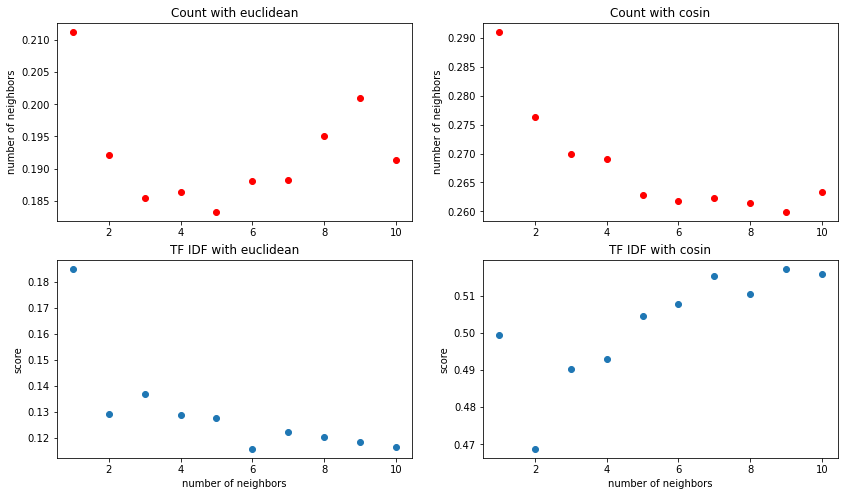

In [30]:
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.scatter(k, score_cnt_eu, color='r')
ax1.set_title("Count with euclidean")
ax1.set_ylabel('number of neighbors')

ax2.scatter(k, score_cnt_cs, color='r')
ax2.set_title("Count with cosin")
ax2.set_ylabel('number of neighbors')

ax3.scatter(k, score_tfidf_eu)
ax3.set_title("TF IDF with euclidean")
ax3.set_xlabel('number of neighbors')
ax3.set_ylabel('score')

ax4.scatter(k, score_tfidf_cs)
ax4.set_title("TF IDF with cosin")
ax4.set_xlabel('number of neighbors')
ax4.set_ylabel('score')


Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [31]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [32]:
test_data = newsgroups['data']
test_target = newsgroups['target']

In [33]:
X_test_tfidf = vectorizer_tfidf.transform(test_data)

In [34]:
clf = MyKNeighborsClassifier(n_neighbors=bestk, metric='cosine')
clf.fit(X_tfidf, target)
clf_pred = clf.predict(X_test_tfidf)

accuracy_score(test_target, clf_pred)

0.459506107275624

## Выводы
* разряженность матриц положительно повлияла на качество алгоритма;

* для анализа текста оказалось лучше использовать косинусную метрику, поскольку она определяет не расстояние, а похожесть двух текстов;

* использование $TF \ IDF$ позволило значительно улучшить качество предсказания, поскольку позволяет оценить значимость слова для данного текста, а не просто факт его наличия;

* анализируя полученные графики, можно заметить, что для евклидовой метрики число $ k = 1 $ наилучший параметр. Предполагаю, что это связано с поиском именно **совпадающих** слов, поскольку в этом случае они похоже по словесному содержанию, но смысловые их части различаются. Иначе обстоит дело с косинусной метрикой. В этом случае выбирабтся наиболее **схожие** тексты. В этом случае, при увеличении числа рассматриваемых соседей до определенного $k$ улучшается качество прогноза, однако при дальнейшем увеличении качество падает, поскольку возникает "переобучение" ;

* точность на тесте оказалась ниже, чем точность на валидации. В первую очередь это связано с появлением в тестовой выборке новых слов (новых значимых слов), отсутствующих в тренировочной выборке и ограниченностью самой тестовой выборки. В то же время на качество повлияло ограничение частот словоря (см. замечание) в силу снижения репрезентативности и так ограниченной выборки. 

Предполагаю, что низкая точность полученна из за:
* использования непараметрического алгоритма;
* большой разницы в числе экземпляров классов (экземпляров 10 класса 600, а экземпляров 19 класса 377).


**Замечание** 
* ограничение словаря по частотности заметно влияет на качество решения. Скорее всего это связано с выбрасыванием из рассмотрения редко встречаемых, но важных (ключевых) слов. При этом для такого словаря наиболее оптимальный параметр k = 1. Но в этом случае решение на тестовой выборке сильно отличается от валидации (для бо'льшего k различие не столь существенное)

In [35]:
accuracy_score(
    test_target[test_target == 10],
    clf_pred[test_target == 10]
)

0.6340852130325815

In [36]:
accuracy_score(
    test_target[test_target == 19],
    clf_pred[test_target == 19]
)

0.1952191235059761

In [37]:
vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(data)

vectorizer_tfidf = TfidfVectorizer()
X_tfidf = vectorizer_tfidf.fit_transform(data)

In [38]:
bestk, score_cnt_eu = kscores(X_count, target, K=k, metric='euclidean')
print(bestk)

1


In [39]:
bestk, score_cnt_cs = kscores(X_count, target, K=k, metric='cosine')
print(bestk)

1


In [40]:
bestk, score_tfidf_eu = kscores(X_tfidf, target, K=k, metric='euclidean')
print(bestk)

1


In [41]:
bestk, score_tfidf_cs = kscores(X_tfidf, target, K=k, metric='cosine')
print(bestk)

1


Text(0, 0.5, 'score')

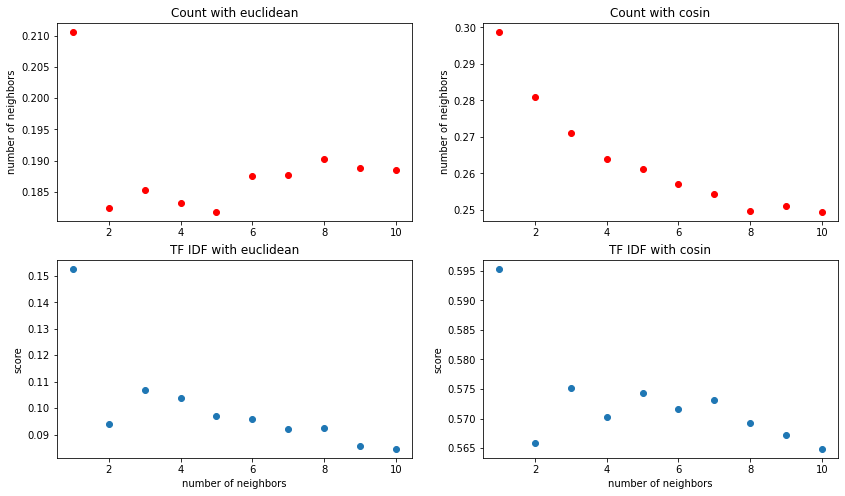

In [42]:
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.scatter(k, score_cnt_eu, color='r')
ax1.set_title("Count with euclidean")
ax1.set_ylabel('number of neighbors')

ax2.scatter(k, score_cnt_cs, color='r')
ax2.set_title("Count with cosin")
ax2.set_ylabel('number of neighbors')

ax3.scatter(k, score_tfidf_eu)
ax3.set_title("TF IDF with euclidean")
ax3.set_xlabel('number of neighbors')
ax3.set_ylabel('score')

ax4.scatter(k, score_tfidf_cs)
ax4.set_title("TF IDF with cosin")
ax4.set_xlabel('number of neighbors')
ax4.set_ylabel('score')

In [43]:
X_test_tfidf = vectorizer_tfidf.transform(test_data)

In [44]:
clf = MyKNeighborsClassifier(n_neighbors=bestk, metric='cosine')
clf.fit(X_tfidf, target)
clf_pred = clf.predict(X_test_tfidf)

accuracy_score(test_target, clf_pred)

0.5088953797132236